# Equity Premium Linear Forecast

This notebook replicates the experiment of Rapach, D. E., Strauss, J. K., & Zhou, G. (2010). Out-of-Sample Equity Premium Prediction: Combination Forecasts and Links to the Real Economy. The Review of Financial Studies, 23(2), 821–862. https://doi.org/10.1093/rfs/hhp063

The first section predicts the equity premium using each individual economic variable. The second section combines all of the economic variables to predict the equity premium.

This notebook refers to the following three papers:

1. Rapach, D. E., Strauss, J. K., & Zhou, G. (2010). Out-of-Sample Equity Premium Prediction: Combination Forecasts and Links to the Real Economy. The Review of Financial Studies, 23(2), 821–862. https://doi.org/10.1093/rfs/hhp063

2. Welch, I., & Goyal, A. (2008). A Comprehensive Look at The Empirical Performance of Equity Premium Prediction. Review of Financial Studies, 21(4), 1455–1508. https://doi.org/10.1093/rfs/hhm014

3. Lu, Y. (Jacques), & Han, Y. (2022). Macroeconomic Extrapolation, Machine Learning, and Equity Risk Premium Forecast (SSRN Scholarly Paper No. 4102419). https://doi.org/10.2139/ssrn.4102419

The content:

   [1. Individual prediction model](##1.-individual-prediction-model)
   
   [2. Combining prediction model](##2.-combining-prediction-model)

   [3. Historical Average](##3.-historical-average)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../module')
from data_handler import get_econ_predictors

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

## 1. Individual prediction model

For each individual economic variable, we consider the same prediction model.

$$
\begin{equation}
r_{t+1}=\alpha_i+\beta_i x_{i, t}+\varepsilon_{t+1}
\end{equation}
$$

For each individual prediction model, we utilize the expanding window. According to (Rapach 2010), we consider three out-of-sample (OOS) peridos, i.e. 1965/01 - 2005/04, 1976/1 – 2005/4, 2000/1 – 2005/4. We use the first period as example, then replicate the same process on other periods. No matter which OOS period, we assume the same in-sample starting date as 1947/1.

In [3]:
START_DATE_TOTAL = '1947-01'
START_DATE_OOS_X = '1954-12'
START_DATE_OOS_Y = '1955-01'
END_DATE = '2005-04'

econ_predictors = get_econ_predictors(START_DATE=START_DATE_TOTAL, END_DATE=END_DATE)
equity_premium = econ_predictors.pop('Equity Premium')
econ_predictors = econ_predictors[:-1] # drop the last element, because there's no OOS prediction true value for the last date
equity_premium = equity_premium[1:] # shift the label 1 day backwards to make it prediction problem

econ_predictors_oos = econ_predictors[START_DATE_OOS_X:END_DATE]
equity_premium_oos = equity_premium[START_DATE_OOS_Y:END_DATE]

oos_size = len(equity_premium_oos)

In [4]:
def get_linear_prediction(X_train:np.array, y_train:np.array, X_test:np.array) -> np.array:
    """
    Fit a linear regression model on the training data and get predictions on the test data
    
    :param X_train: Training data
    :param y_train: Training labels
    :param X_test: Test data

    :return: Linear prediction
    """
    model = LinearRegression().fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
    prediction = model.predict(X_test.reshape(-1,1))

    return prediction


In [53]:
get_linear_prediction(X_train=econ_predictors.iloc[0:214,0].values, 
                      y_train=equity_premium.iloc[0:214].values, 
                      X_test=econ_predictors.iloc[215,0])

array([[0.00217315]])

In [5]:
def get_ts_predictions(X:np.ndarray, y:np.ndarray, X_test_size:int) -> np.ndarray:
    """
    Build linear models on training data in expanding window way.
    Get a series of predictions from the test data using the fit models.

    Parameters
    ----------
    X : np.array
        Whole sample of feature data.
        shape = (n_samples, 1)
    y : np.array
        Whole sample of labels.
        shape = (n_samples, 1)
    X_test_size : int
        Size of the test sample.

    Returns
    -------
    np.array
        Time series predictions.
        shape = (n_samples, 1)
    """

    expanding_window_idx_generator = TimeSeriesSplit(n_splits = X_test_size, test_size=1)
    prediction = [get_linear_prediction(X_train=X[train_index], 
                                        y_train=y[train_index], 
                                        X_test=X[test_index])
                                        for _, (train_index, test_index) in enumerate(expanding_window_idx_generator.split(econ_predictors))]
    prediction = np.array(prediction).reshape(-1)
    return prediction


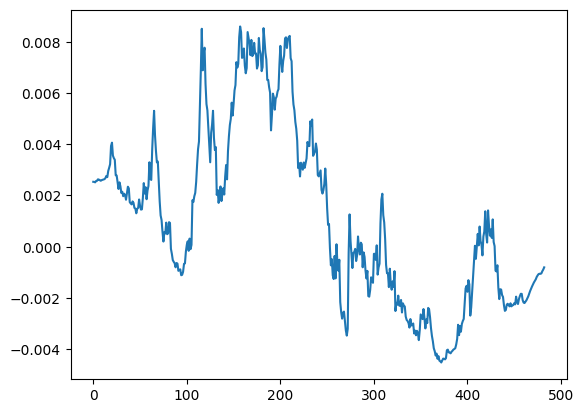

In [101]:
pred = get_ts_predictions(X=econ_predictors['Dividend Price Ratio'].values, 
                          y=equity_premium.values,
                          X_test_size=len(econ_predictors_oos))
plt.plot(pred)

repeat the time series predictions of the equity premium over each individual economic variable

In [6]:
prediction_dict = {predictor: get_ts_predictions(X=econ_predictors[predictor].values, 
                                                 y=equity_premium.values, 
                                                 X_test_size=oos_size)
                   for predictor in econ_predictors.columns}

In [7]:
prediction_df = pd.DataFrame(prediction_dict)
prediction_df.index = equity_premium_oos.index
prediction_df

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,Term Spread,Default Yield Spread,Default Return Spread,Inflation
1955-01,-0.004844,0.000069,0.004311,0.009642,0.006988,-0.003453,0.009169,0.009685,0.007821,0.013279,0.012838,0.006059,0.012579,0.011347
1955-02,-0.003725,-0.000181,0.004975,0.009463,0.017906,-0.002089,0.009090,0.009186,0.007525,-0.015223,0.013743,0.005035,-0.002340,0.009833
1955-03,-0.003232,-0.000354,0.005064,0.009115,0.005238,-0.001959,0.009498,0.009534,0.007164,0.000727,0.014647,0.005794,0.007849,0.009748
1955-04,-0.003076,-0.000716,0.004931,0.008697,0.017181,-0.001365,0.009283,0.008459,0.006883,0.015251,0.012398,0.002214,0.008479,0.009564
1955-05,-0.001711,0.001855,0.005943,0.008584,0.005286,-0.000012,0.009180,0.006199,0.007711,0.007808,0.009819,0.004414,0.009310,0.009879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12,-0.001057,-0.000900,0.001672,0.000743,0.003810,0.002620,0.004372,0.007009,0.004409,-0.000831,0.007148,0.002406,0.003381,0.006551
2005-01,-0.001041,-0.000934,0.001600,0.001011,0.003937,0.002703,0.004274,0.006904,0.004617,0.006167,0.006399,0.002460,0.003333,0.011826
2005-02,-0.000955,-0.001189,0.001711,0.000792,0.003827,0.002610,0.004129,0.006626,0.004729,0.006795,0.005422,0.002330,0.003188,0.004552
2005-03,-0.000891,-0.000852,0.001698,0.000955,0.003840,0.002648,0.004459,0.006360,0.004628,0.000765,0.005254,0.002211,0.003339,0.000091


## 2. Combining prediction model

We consider four different combination methods for equity premium prediction:

1. Mean
2. Median
3. Trimmed Mean
4. DMSPE-based (discounted mean squared prediction error)

### 2.1 Mean combination

In [191]:
mean = prediction_df.values.mean(axis=1)

### 2.2 Median combination

In [195]:
median = np.median(prediction_df.values, axis=1)

## 2.3 Trimmed mean

In [138]:
prediction_copy = np.copy(prediction_df.values)
prediction_copy.sort(axis=1)
prediction_trimmed = prediction_copy[:,1:-1]
trimmed_mean = prediction_trimmed.mean(axis=1)
trimmed_mean

array([ 7.25460476e-03,  5.04303106e-03,  5.61821081e-03,  7.00658772e-03,
        6.34133775e-03,  6.86392868e-03,  6.76132900e-03,  9.02264028e-03,
        8.71977426e-03,  8.93647501e-03,  7.99433517e-03,  8.66065303e-03,
        8.33156324e-03,  7.10176591e-03,  7.64186715e-03,  9.37921519e-03,
        8.45425269e-03,  8.46825573e-03,  7.81754892e-03,  7.44026662e-03,
        7.46703351e-03,  6.79953126e-03,  6.21806751e-03,  5.74638854e-03,
        4.66682096e-03,  6.92728837e-03,  4.40965448e-03,  3.97379410e-03,
        3.28280423e-03,  6.00475451e-03,  4.91995056e-03,  5.62242052e-03,
        5.08206107e-03,  3.77990171e-03,  2.30666763e-03,  5.40135146e-03,
        1.57090452e-03,  3.47010085e-03,  5.84291432e-03,  6.18848169e-03,
        6.91603972e-03,  6.16114990e-03,  5.56394352e-03,  5.76157526e-03,
        5.25868725e-03,  5.62186042e-03,  6.51645181e-03,  6.51029517e-03,
        5.92963668e-03,  5.86667624e-03,  6.81641846e-03,  6.52334975e-03,
        6.27359518e-03,  

### 2.4 DMSPE-based combination

This DMSPE-based combination approach firstly computes the DMSPE (discount mean square prediction error)

\begin{equation}
\phi_{i, t}=\sum_{s=m}^{t-1} \theta^{t-1-s}\left(r_{s+1}-\hat{r}_{i, s+1}\right)^2
\end{equation}

Here $m$ is the time origin of hold out period in the OOS prediction. We adopt two different values for the discount factor, i.e. $\theta = 1\; or\; 0.9$. Then we define the weight for each individual prediction in the combination prediction.

\begin{equation}
\omega_{i, t}=\phi_{i, t}^{-1} / \sum_{j=1}^N \phi_{j, t}^{-1}
\end{equation}

In [186]:
true_values = equity_premium_oos.values.reshape(-1,1)
theta = 0.9
discount_power = np.arange(len(true_values), 0, -1) - 1
discounted_theta = np.power(theta, discount_power).reshape(-1,1)
squared_prediction_error = np.square(prediction_df.values - true_values)
phi = np.cumsum(squared_prediction_error * discounted_theta, axis=0)
weight = (1 / phi) / np.sum(1 / phi, axis=1, keepdims=True)
DMSPE_prediction = np.sum(weight * prediction_df.values, axis=1)

In [203]:
np.vstack([mean, median, trimmed_mean, DMSPE_prediction]).T

array([[0.00682075, 0.00849502, 0.0072546 , 0.01096064],
       [0.00451422, 0.00628023, 0.00504303, 0.0053148 ],
       [0.00563094, 0.00647924, 0.00561821, 0.00566639],
       ...,
       [0.00318322, 0.00350758, 0.00324664, 0.00322512],
       [0.0024646 , 0.0024294 , 0.00241964, 0.00249652],
       [0.00228405, 0.00249065, 0.00236896, 0.00227835]])

wrap up everything into a function

In [8]:
def get_combined_prediction(true_values: np.ndarray, prediction: np.ndarray, prediction_index: pd.core.indexes, holdout_size: int) -> pd.DataFrame:
    """
    This function retruns four combined predictions from each individual economic model
    
    Parameters
    ----------
    true_values : np.ndarray
    
    prediction : np.ndarray
    
    Returns
    -------
    np.ndarray
    """
    mean = prediction.mean(axis=1)

    median = np.median(prediction, axis=1)
    
    prediction_copy = np.copy(prediction)
    prediction_copy.sort(axis=1)
    prediction_trimmed = prediction_copy[:,1:-1]
    trimmed_mean = prediction_trimmed.mean(axis=1)

    theta_1 = 1
    theta_2 = 0.9
    discount_power = np.arange(len(true_values), 0, -1) - 1
    discounted_theta_1 = np.power(theta_1, discount_power).reshape(-1,1)
    discounted_theta_2 = np.power(theta_2, discount_power).reshape(-1,1)
    squared_prediction_error = np.square(prediction - true_values)
    phi_1 = np.cumsum(squared_prediction_error * discounted_theta_1, axis=0)
    phi_2 = np.cumsum(squared_prediction_error * discounted_theta_2, axis=0)
    weight_1 = (1 / phi_1) / np.sum(1 / phi_1, axis=1, keepdims=True)
    weight_2 = (1 / phi_2) / np.sum(1 / phi_2, axis=1, keepdims=True)
    DMSPE_prediction_1 = np.sum(weight_1 * prediction, axis=1)
    DMSPE_prediction_2 = np.sum(weight_2 * prediction, axis=1)

    prediction_mat = np.vstack([mean, median, trimmed_mean, DMSPE_prediction_1, DMSPE_prediction_2]).T
    prediction_df = pd.DataFrame(prediction_mat, columns=['Mean', 'Median', 'Trimmed mean', 'DMSPE theta 1', 'DMSPE theta 0.9'], index=prediction_index)
    prediction_df = prediction_df.iloc[holdout_size:, :]
    
    return prediction_df

In [9]:
combined_prediction = get_combined_prediction(true_values=equity_premium_oos.values.reshape(-1,1), 
                                            prediction=prediction_df.values,
                                            prediction_index=equity_premium_oos.index,
                                            holdout_size=10 * 12)
combined_prediction

,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9
1965-01,0.003980,0.004367,0.004238,0.003938,0.004170
1965-02,0.004490,0.004705,0.004530,0.004452,0.004634
1965-03,0.004406,0.004592,0.004372,0.004361,0.004407
1965-04,0.004070,0.004275,0.004233,0.004022,0.004236
1965-05,0.004404,0.004655,0.004381,0.004360,0.004463
...,...,...,...,...,...
2004-12,0.002953,0.003001,0.002937,0.002959,0.003058
2005-01,0.003804,0.003635,0.003539,0.003815,0.003817
2005-02,0.003183,0.003508,0.003247,0.003186,0.003225
2005-03,0.002465,0.002429,0.002420,0.002462,0.002497


## 3. Historical Average

\begin{equation}
\bar{r_{t+1}} = \frac{\sum_{i=1}^t r_i}{t}
\end{equation}

In [10]:
def get_benchmark_of_equity_premium_prediction(equity_premium:np.ndarray, 
                                               prediction_size:int, 
                                               holdout_size:int,
                                               prediction_index: pd.core.indexes) -> pd.DataFrame:
    """
    This function returns the historical average of the equity premium.
    
    Parameters
    ----------
    equity_premium : np.ndarray
    prediction_size : int
    holdout_size : int

    Returns
    -------
    np.ndarray
    """

    historical_average = np.cumsum(equity_premium) / np.arange(1, len(equity_premium) + 1)
    historical_average = historical_average[-prediction_size+holdout_size-1:-1]
    benchmark = np.vstack([historical_average, equity_premium[-prediction_size+holdout_size:]]).T
    benchmark_df = pd.DataFrame(benchmark, 
                                columns = ['Historical Average', 'Equity Premium'], 
                                index = prediction_index[-prediction_size+holdout_size:])
    
    return benchmark_df

In [11]:
benchmark_df = get_benchmark_of_equity_premium_prediction(equity_premium=equity_premium.values,
                                                        prediction_size=len(equity_premium_oos),
                                                        holdout_size=10 * 12,
                                                        prediction_index=equity_premium.index)

In [12]:
prediction_total = pd.concat([prediction_df, combined_prediction, benchmark_df], axis=1).dropna()

array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

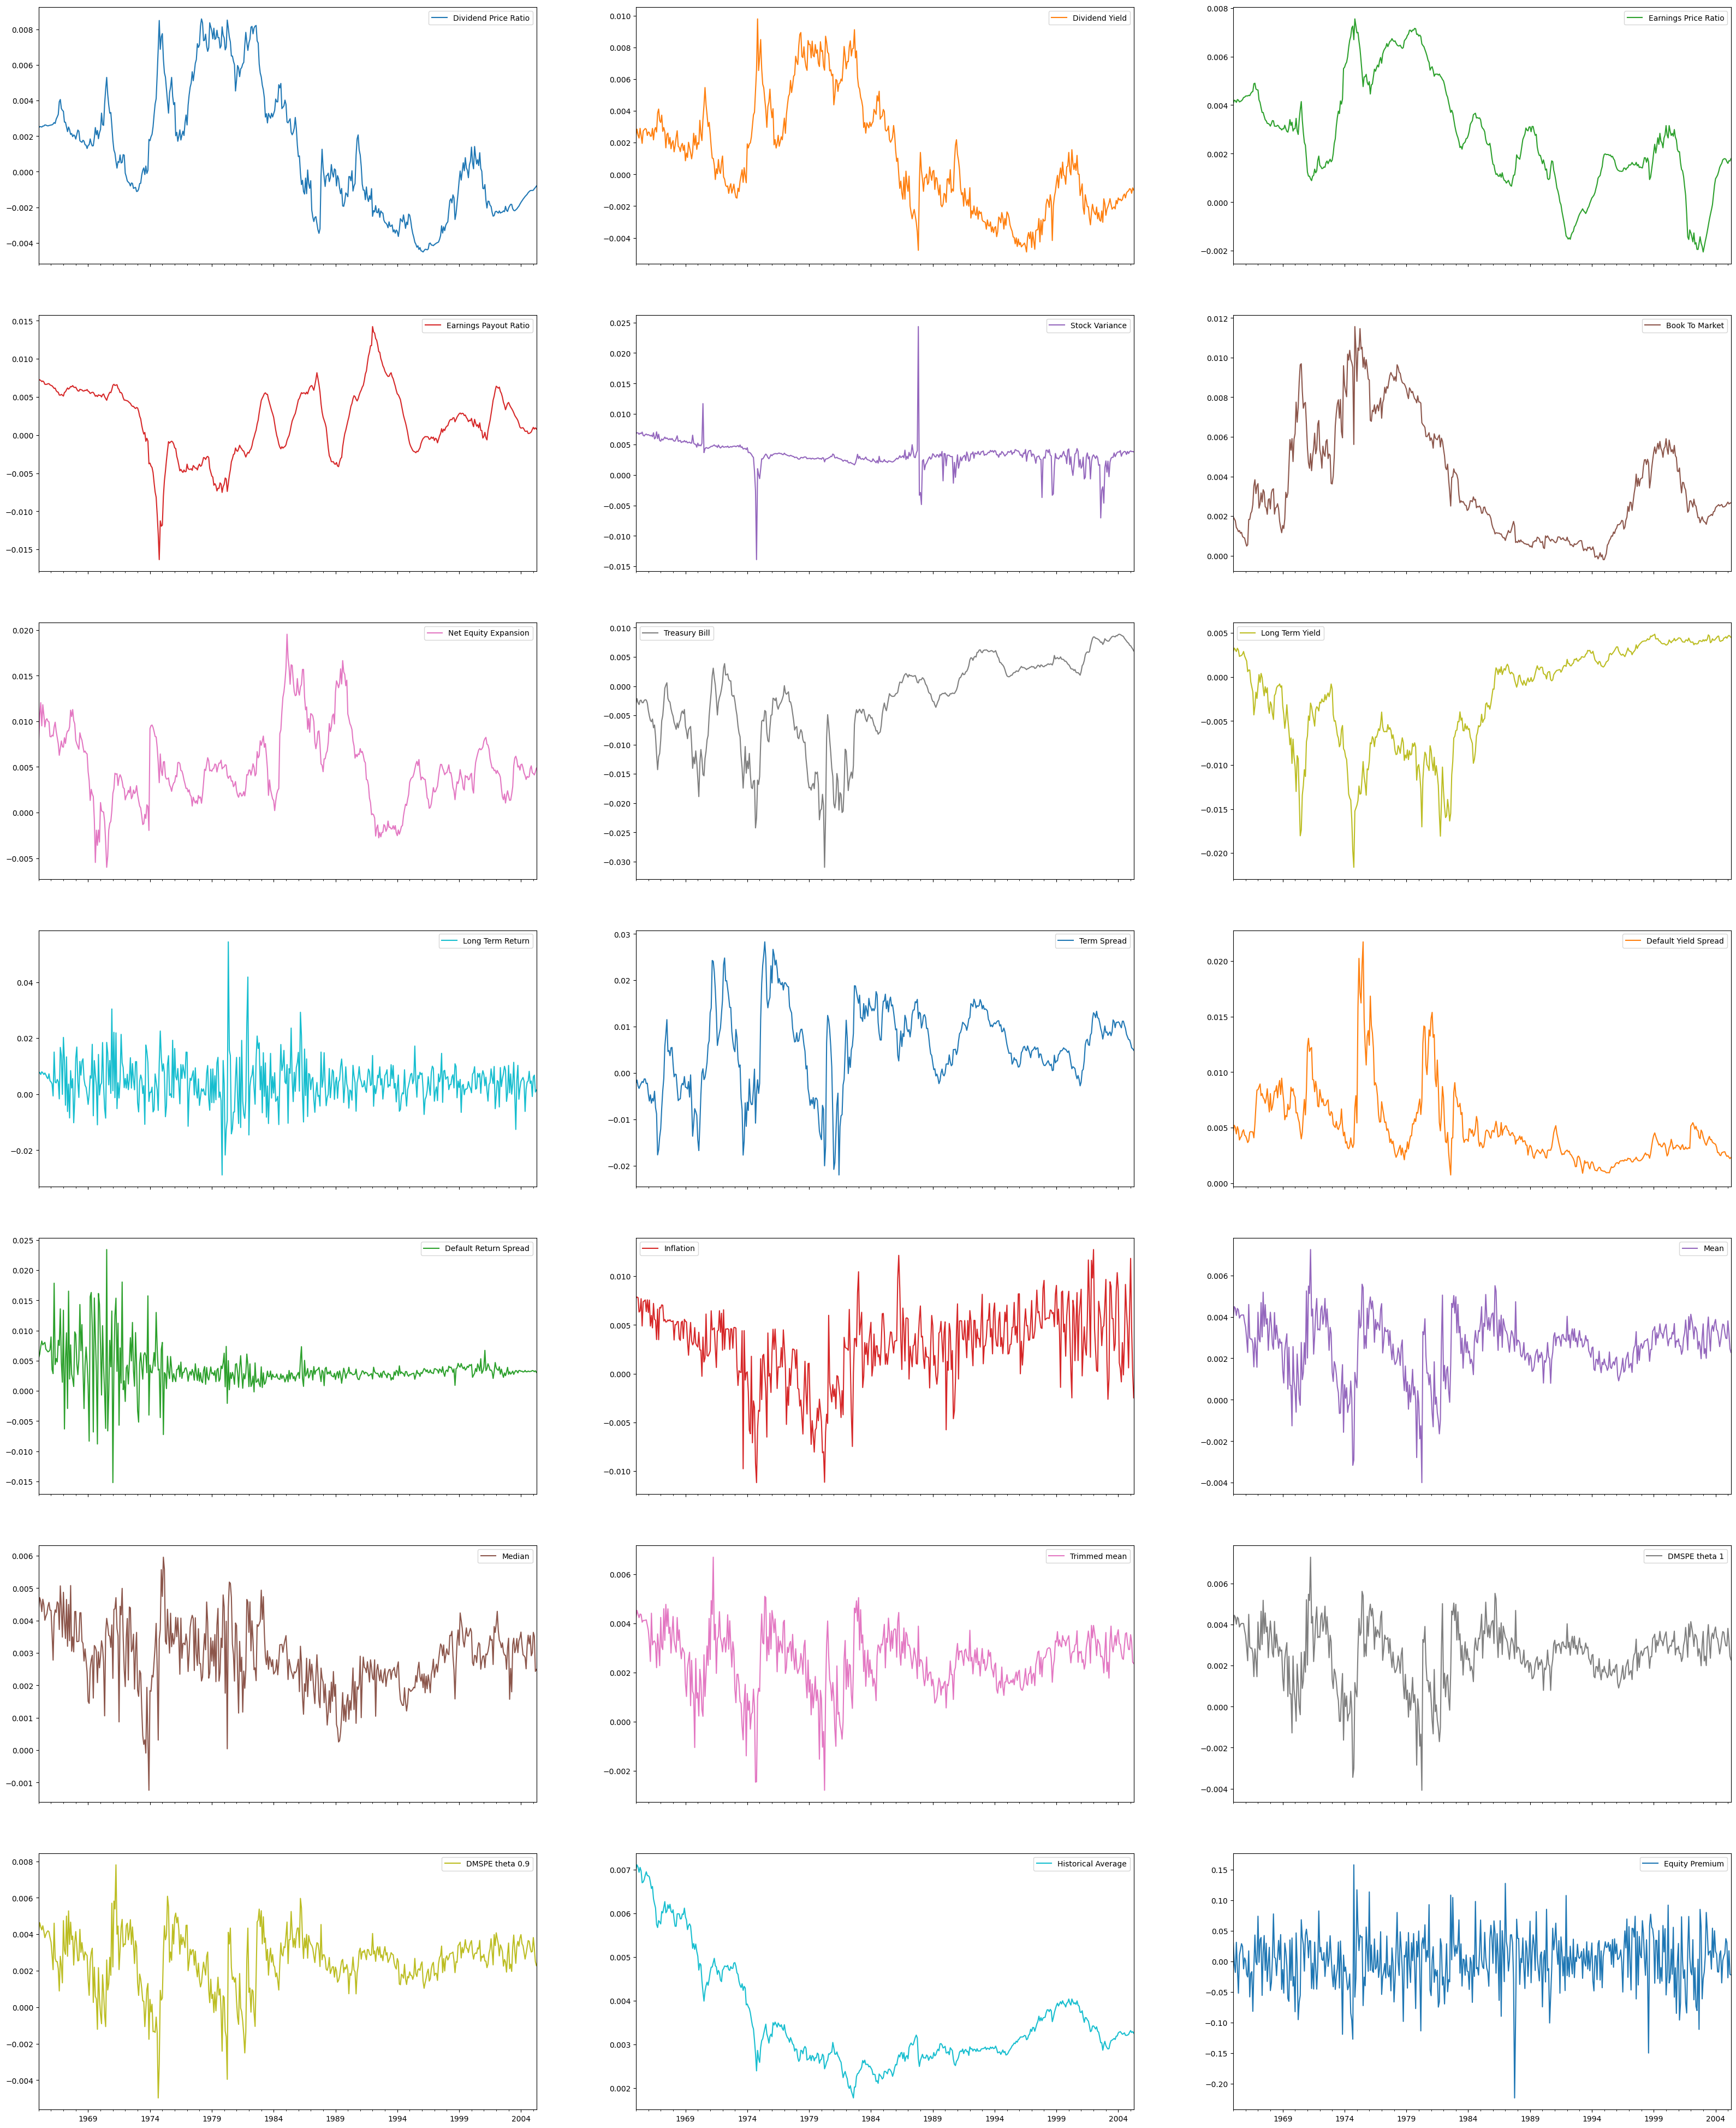

In [15]:

prediction_total.plot(subplots = True,
                        use_index = True,
                        fontsize = 10,
                        layout = (7,3), 
                        figsize = (40,50))

In [16]:
prediction_total.corr()

,Dividend Price Ratio,Dividend Yield,Earnings Price Ratio,Earnings Payout Ratio,Stock Variance,Book To Market,Net Equity Expansion,Treasury Bill,Long Term Yield,Long Term Return,...,Default Yield Spread,Default Return Spread,Inflation,Mean,Median,Trimmed mean,DMSPE theta 1,DMSPE theta 0.9,Historical Average,Equity Premium
Dividend Price Ratio,1.000000,0.981217,0.839531,-0.462034,-0.036497,0.654785,0.080458,-0.820604,-0.828137,0.015857,...,0.449555,0.002232,-0.514863,-0.233383,0.352073,-0.129981,-0.242210,-0.255900,-0.040761,-0.016829
Dividend Yield,0.981217,1.000000,0.825963,-0.448546,-0.048239,0.639259,0.113157,-0.790180,-0.802151,0.074783,...,0.480320,-0.011855,-0.481315,-0.163886,0.392088,-0.061577,-0.172402,-0.179621,-0.043285,-0.014625
Earnings Price Ratio,0.839531,0.825963,1.000000,-0.699800,0.062727,0.722019,0.133003,-0.799729,-0.727428,-0.014361,...,0.395071,0.046602,-0.527783,-0.325051,0.256104,-0.235169,-0.334469,-0.334179,0.080252,-0.054324
Earnings Payout Ratio,-0.462034,-0.448546,-0.699800,1.000000,0.328874,-0.578103,-0.105162,0.471856,0.486972,0.042391,...,-0.104823,0.114245,0.548907,0.448526,0.012508,0.426019,0.449333,0.440644,0.391487,-0.004112
Stock Variance,-0.036497,-0.048239,0.062727,0.328874,1.000000,-0.042250,0.002989,-0.037426,0.060748,0.011276,...,0.126637,0.156190,0.224529,0.215737,0.167460,0.248808,0.208291,0.206016,0.546020,-0.183539
Book To Market,0.654785,0.639259,0.722019,-0.578103,-0.042250,1.000000,-0.246136,-0.588097,-0.684660,-0.005969,...,0.473581,0.015162,-0.480934,-0.234493,0.309315,-0.152046,-0.241872,-0.256077,0.008132,-0.083890
Net Equity Expansion,0.080458,0.113157,0.133003,-0.105162,0.002989,-0.246136,1.000000,-0.024418,0.108328,0.063711,...,-0.014629,0.020071,0.071984,0.235832,0.030133,0.233760,0.234232,0.238191,0.035284,0.023021
Treasury Bill,-0.820604,-0.790180,-0.799729,0.471856,-0.037426,-0.588097,-0.024418,1.000000,0.879366,0.001461,...,-0.391936,-0.053543,0.572319,0.567704,-0.074149,0.487407,0.577996,0.575591,-0.030227,0.085372
Long Term Yield,-0.828137,-0.802151,-0.727428,0.486972,0.060748,-0.684660,0.108328,0.879366,1.000000,0.021678,...,-0.501632,0.036633,0.590659,0.415715,-0.121935,0.365173,0.423105,0.440527,0.156559,0.045768
Long Term Return,0.015857,0.074783,-0.014361,0.042391,0.011276,-0.005969,0.063711,0.001461,0.021678,1.000000,...,0.095196,0.244553,0.091689,0.485488,0.339746,0.446278,0.477767,0.474348,0.060537,0.085214


In [122]:
prediction_total.to_csv('../../data/linear_prediction.csv')